In [76]:
import pandas as pd
import sweetviz as sv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import OrdinalEncoder

In [77]:
df_user = pd.read_csv('./csv/dtt_users.csv')
df_country = pd.read_csv('./csv/dtt_country.csv')[['country_id','country_code','country_phonecode','country_name']]

order_col = [
    'customer_id','order_product_id','browser', 'platform', # ref
    'customer_firstname','customer_lastname','customer_email','customer_gender', #customer details
    'customer_nationality','customer_country','customer_phone_iso','customer_phone_code', # convert to country id
    'order_price_paid','order_state','order_payment_by',
    'order_quantity_infant','order_quantity_children','order_quantity_adult','order_quantity_elder', # create private, group, family, kid, adult
    'order_departure_date','order_date',# columns >> date in year, mount, year
    ]
df_order = pd.read_csv('./csv/dtt_order.csv')[order_col]

countryCode_to_id = {i[1][1] : i[1][0] for i in df_country.iterrows()}
phoneCode_to_id = {}
countryName_to_id = {i[1][3] : i[1][0] for i in df_country.iterrows()}
for i in df_country.iterrows():
    val = i[1][0]
    if len(i[1][2].split(',')) > 1:
        for j in i[1][2].split(','):
            phoneCode_to_id[j] = val
    else:
        phoneCode_to_id[i[1][2]] = val

/var/folders/5g/90_bh_2146gffg2__wzbyb780000gn/T/ipykernel_99697/1251667730.py:12: DtypeWarning: Columns (2,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_order = pd.read_csv('./csv/dtt_order.csv')[order_col]


In [78]:
def has_numbers(inputString):
    return bool(re.search(r'\d', inputString))

def encode_gender(inputString):
    if 'Mr.' == inputString or 'mr.' in inputString:
        return 0
    elif 'Ms.' == inputString or 'ms.' in inputString:
        return 1
    elif 'Mrs.' == inputString or 'mrs.' in inputString:
        return 2
    else:
        return 3

def encode_phone_code(inputFloat):
    try:
        return phoneCode_to_id[str(int(inputFloat))]
    except:
        print(int(inputFloat))

def encode_order_payment_by(inputString):
    if 'creditcard' == inputString:
        return 1
    elif 'paypal' == inputString:
        return 2
    else:
        return 0

In [79]:
df_order_v1 = df_order[order_col]
# drop na
na_index_v1 = df_order_v1[df_order_v1['customer_country'].isna()].index
df_order_v1 = df_order_v1.drop(na_index_v1)

# drop test
test_index_v1 = df_order_v1[df_order_v1['customer_email'].map(lambda x: 'test' in str(x) or '@mail.com' in str(x) or '360' in str(x))].index
df_order_v1 = df_order_v1.drop(test_index_v1)

test_index_v2 = df_order_v1[df_order_v1['customer_email'].map(lambda x: 'mitkung' in str(x) or 'suphattra' in str(x))].index
df_order_v1 = df_order_v1.drop(test_index_v2)

test_index_v3 = df_order_v1[df_order_v1['customer_firstname'].map(lambda x: 'admin' in str(x) or 'test' in str(x) or 'Thanadol' in str(x) or 'Test' in str(x))].index
df_order_v1 = df_order_v1.drop(test_index_v3)

test_index_v3 = df_order_v1[df_order_v1['customer_firstname'].map(lambda x: ('asd' in str(x) or 'dsd' in str(x) or 'xx' in str(x)) and not 'Jasdeep' in str(x))].index
df_order_v1 = df_order_v1.drop(test_index_v3)

# clean
df_order_v1.loc[3627, 'customer_firstname'] = 'Jennyhan'
df_order_v1['customer_firstname'] = df_order_v1['customer_firstname'].map(lambda x: re.sub('[0-9#$;:]+', '', x))
df_order_v1['customer_lastname'] = df_order_v1['customer_lastname'].map(lambda x: re.sub('[0-9#$;:]+', '', x))
df_order_v1['customer_nationality'] = df_order_v1['customer_nationality'].map(lambda x: re.sub('ไทย|Thailand', 'thai', x))
df_order_v1['customer_nationality'] = df_order_v1['customer_nationality'].map(lambda x : x.lower())

# encode
df_order_v1['customer_gender'] = df_order_v1['customer_gender'].map(lambda x : encode_gender(str(x)))
df_order_v1['customer_country'] = df_order_v1['customer_country'].map(lambda x : countryName_to_id[x] if x != '' else x)

df_order_v1.fillna(value={'customer_phone_iso': -1, 'customer_phone_code':-1, 'order_payment_by': 0}, inplace=True)
df_order_v1['customer_phone_iso'] = df_order_v1['customer_phone_iso'].map(lambda x : -1 if x == -1 else countryCode_to_id[x])
df_order_v1['customer_phone_code'] = df_order_v1['customer_phone_code'].map(lambda x : -1 if x == -1 else encode_phone_code(x))
df_order_v1['order_payment_by'] = df_order_v1['order_payment_by'].map(lambda x : encode_order_payment_by(str(x)))

df_order_v1['customer_phone_iso'] = np.where(df_order_v1['customer_phone_iso']==-1, df_order_v1['customer_country'], df_order_v1['customer_phone_iso'])
df_order_v1['customer_phone_code'] = np.where(df_order_v1['customer_phone_code']==-1, df_order_v1['customer_country'], df_order_v1['customer_phone_iso'])

enc = OrdinalEncoder(dtype='int8', encoded_missing_value=-1)
cat_cols = ['browser', 'platform', 'order_state']
df_order_v1[cat_cols] = enc.fit_transform(df_order_v1[cat_cols])

# change dtype to int
int_cols = ['customer_phone_iso', 'customer_phone_code','order_price_paid', 'customer_id']
df_order_v1['customer_phone_iso'] = np.where(df_order_v1['customer_phone_iso']==-1, df_order_v1['customer_country'], df_order_v1['customer_phone_iso'])
df_order_v1['customer_phone_code'] = np.where(df_order_v1['customer_phone_code']==-1, df_order_v1['customer_country'], df_order_v1['customer_phone_iso'])
df_order_v1[int_cols] = df_order_v1[int_cols].astype('int64')

# convert to datetime
df_order_v1[['order_departure_date','order_date']] = df_order_v1[['order_departure_date','order_date']].apply(pd.to_datetime)

df_order_v1['booked_days'] =  df_order_v1['order_departure_date']-df_order_v1['order_date']
df_order_v1['booked_days'] = df_order_v1['booked_days'].map(lambda x: x.days)

df_order_v1['departure_month'] = df_order_v1['order_departure_date'].map(lambda x:x.year)
df_order_v1['departure_month'] = df_order_v1['order_departure_date'].map(lambda x:x.month)
df_order_v1['departure_day'] = df_order_v1['order_departure_date'].map(lambda x:x.day)

df_order_v1['departure_DayofYear'] = df_order_v1['order_departure_date'].map(lambda x:x.day_of_year)
df_order_v1['departure_DayofWeek'] = df_order_v1['order_departure_date'].map(lambda x:x.day_of_week)

# df_order_v1['order_price_paid'] = df_order_v1['order_price_paid'].astype('int64')
# df_order_v1['customer_id'] = df_order_v1['customer_id'].astype('int64')

# test_index_v4 = df_order_v1[df_order_v1['customer_email'].map(lambda x: 'daytriptour' in str(x) or 'support' in str(x))].index
# df_order_v1 = df_order_v1.drop(test_index_v4)

# test_index_v5 = df_order_v1[df_order_v1['customer_email'].map(lambda x: 'dolavic' in str(x) or 'thanadol' in str(x))].index
# df_order_v1 = df_order_v1.drop(test_index_v5)

In [80]:
ls_encode = []
for i in enc.categories_:
    ls_encode.append(i.tolist())
ls_encode

[['Android Browser',
  'AppleWebKit',
  'Chrome',
  'Edge',
  'Firefox',
  'MSIE',
  'Opera Next',
  'Safari',
  'SamsungBrowser',
  'Vivaldi',
  nan],
 ['Android',
  'Chrome OS',
  'Linux',
  'Macintosh',
  'Windows',
  'iPad',
  'iPhone',
  nan],
 ['cancelled', 'detail_success', 'payment_success']]

In [81]:
# report = sv.analyze(df_order_v1)
# report.show_html('./report/clean_order_v1.html')
# df_order_v1.to_csv('./csv/clean_order_v1.csv')

In [82]:
df_order_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9250 entries, 1285 to 27326
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              9250 non-null   int64         
 1   order_product_id         9250 non-null   int64         
 2   browser                  9250 non-null   int8          
 3   platform                 9250 non-null   int8          
 4   customer_firstname       9250 non-null   object        
 5   customer_lastname        9250 non-null   object        
 6   customer_email           9250 non-null   object        
 7   customer_gender          9250 non-null   int64         
 8   customer_nationality     9250 non-null   object        
 9   customer_country         9250 non-null   int64         
 10  customer_phone_iso       9250 non-null   int64         
 11  customer_phone_code      9250 non-null   int64         
 12  order_price_paid         9250 

In [86]:
df_order_v1.iloc[:10, 9:]

,customer_country,customer_phone_iso,customer_phone_code,order_price_paid,order_state,order_payment_by,order_quantity_infant,order_quantity_children,order_quantity_adult,order_quantity_elder,order_departure_date,order_date,booked_days,departure_month,departure_day,departure_DayofYear,departure_DayofWeek
1285,77,77,77,0,1,0,0,0,2,0,2018-10-29,NaT,NaN,10,29,302,0
1286,77,77,77,4500,2,0,0,0,2,0,2018-10-29,2018-08-29,61.0,10,29,302,0
1296,13,13,13,3440,2,0,1,2,2,0,2018-08-30,2018-08-30,0.0,8,30,242,3
1300,77,77,77,0,1,0,0,0,2,0,2018-08-31,NaT,NaN,8,31,243,4
1303,23,23,23,699,2,0,0,0,1,0,2018-08-30,2018-08-30,0.0,8,30,242,3
1305,13,13,13,0,1,0,0,2,3,0,2018-08-31,NaT,NaN,8,31,243,4
1306,77,77,77,0,1,0,0,0,2,0,2018-08-31,NaT,NaN,8,31,243,4
1309,13,13,13,2250,2,0,0,2,3,0,2018-08-31,2018-08-30,1.0,8,31,243,4
1310,198,198,198,4100,2,0,1,0,2,0,2018-09-01,2018-08-30,2.0,9,1,244,5
1311,158,158,158,0,1,0,0,0,1,0,2018-09-04,NaT,NaN,9,4,247,1


In [74]:
df_order_v1['booked_days'] =  df_order_v1['order_departure_date']-df_order_v1['order_date']
df_order_v1['booked_days'] = df_order_v1['booked_days'].map(lambda x: x.days)

df_order_v1['departure_month'] = df_order_v1['order_departure_date'].map(lambda x:x.year)
df_order_v1['departure_month'] = df_order_v1['order_departure_date'].map(lambda x:x.month)
df_order_v1['departure_day'] = df_order_v1['order_departure_date'].map(lambda x:x.day)

df_order_v1['departure_DayofYear'] = df_order_v1['order_departure_date'].map(lambda x:x.day_of_year)
df_order_v1['departure_DayofWeek'] = df_order_v1['order_departure_date'].map(lambda x:x.day_of_week)

In [66]:
df_order_v1['order_date'][1286].day_of_year

241

In [88]:
df_order_v1[df_order_v1['order_departure_date']<df_order_v1['order_date']]

,customer_id,order_product_id,browser,platform,customer_firstname,customer_lastname,customer_email,customer_gender,customer_nationality,customer_country,...,order_quantity_children,order_quantity_adult,order_quantity_elder,order_departure_date,order_date,booked_days,departure_month,departure_day,departure_DayofYear,departure_DayofWeek
13259,0,173,2,0,Amrish,Sidda,Amrish.sidda@gmail.com,0,indian,105,...,0,3,0,2019-09-21,2019-09-22,-1.0,9,21,264,5
15908,0,82,4,4,desmond,fyffe,juniorfyffe87@outlook.com,0,mixed,101,...,0,2,0,2019-11-20,2019-11-21,-1.0,11,20,324,2
23356,2533,181,2,4,Komonluck,Aing,ai_aung51@hotmail.com,0,thai,218,...,0,2,0,2022-04-14,2022-04-15,-1.0,4,14,104,3
24763,0,181,7,6,Hussain,Basulayb,habasleb@hotmail.com,0,saudi arabia,193,...,0,4,0,2022-08-26,2022-08-28,-2.0,8,26,238,4
25515,2687,34,7,6,Kate,Allen,kate.sam.allen@gmail.com,0,new zealand,171,...,0,5,0,2022-10-10,2022-10-17,-7.0,10,10,283,0
26224,0,34,7,6,Laura,L’Hopital,laura.lhopital@outlook.com,1,australian,13,...,0,2,0,2022-11-27,2022-12-21,-24.0,11,27,331,6


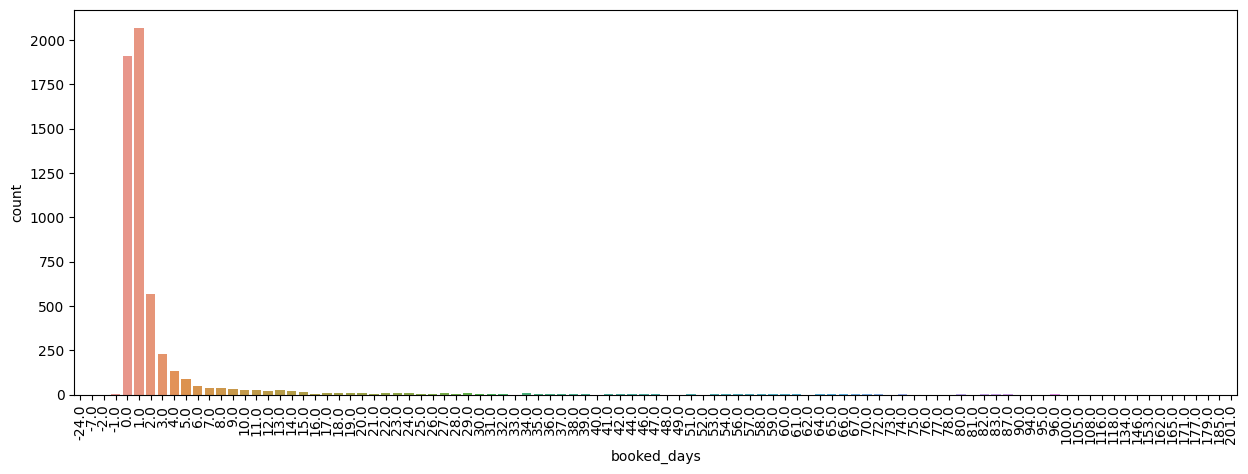

In [63]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df_order_v1, x = 'booked_days')
plt.xticks(rotation=90)
plt.show()

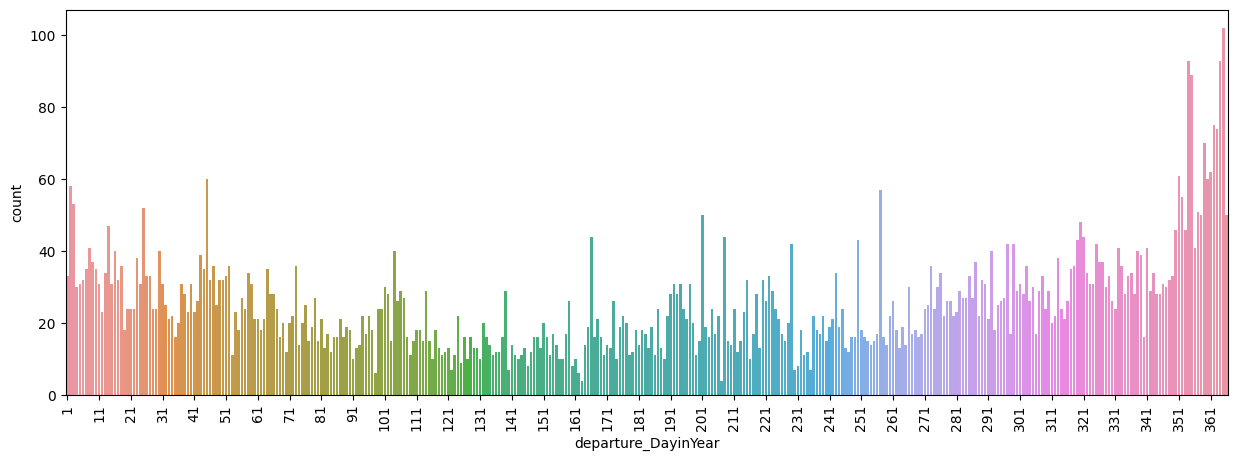

In [73]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df_order_v1, x = 'departure_DayinYear')
plt.xticks(rotation=90)
plt.xticks(range(0, 366,10))
plt.show()

In [72]:
df_order_v1['departure_DayinYear'].value_counts()

365    102
364     93
354     93
355     89
362     75
      ... 
230      7
162      6
98       6
163      4
207      4
Name: departure_DayinYear, Length: 366, dtype: int64